# Dataset

In [41]:
import sys

# add the parent directory to the path so we can import the module
sys.path.append("/data2/eranario/scratch/strawberry-yield-forecasting")

In [42]:
import torch
from src.dataset import StrawberryDataset

In [43]:
# create random seed
torch.manual_seed(12345)

In [44]:
# device is cuda else cpu
device = "cuda" if torch.cuda.is_available() else "cpu"

In [45]:
path_to_counts = "/data2/eranario/data/Strawberry-Yield-Forecasting/"
path_to_weights = "/data2/eranario/data/Strawberry-Yield-Forecasting/weights/weights.csv"
n_seq = 5
seq_l = 3
n_folds = 2
k_fold = 2
use_weights = True
dataset = StrawberryDataset(path_to_counts, path_to_weights, k_fold=k_fold,
                            n_seq=n_seq, seq_l=seq_l, n_folds=n_folds, use_weights=use_weights)

In [46]:
# Check date parsing
months, days, years = dataset.months, dataset.days, dataset.years
print("\nParsed Dates:")
print("Months:", months)
print("Days:", days)
print("Years:", years)


X_data, y_data = dataset.fnX, dataset.fny
print("\nOrganized Data Shapes:")
print("X_data shape:", X_data.shape)  # Expected: (num_samples, num_features)
print("y_data shape:", y_data.shape)  # Expected: (num_samples, num_labels)

# Display sample data from X and y
print("\nSample X_data:", X_data[0][:10])  # Display first 10 features of first sample
print("Sample y_data:", y_data[0])         # Display first sample of y_data

print("\nDataset length (number of samples):", len(dataset))

X_sample, y_sample = dataset[0]
print("\nSample from __getitem__:")
print("X_sample:", X_sample[:10])  # Display first 10 features of X_sample
print("y_sample:", y_sample)


Parsed Dates:
Months: ['06', '06', '07', '07', '07', '07', '07', '07', '08', '08', '08', '08', '08', '09', '09', '09']
Days: ['17', '28', '05', '08', '15', '19', '26', '29', '02', '05', '09', '12', '29', '01', '20', '22']
Years: ['2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022']

Organized Data Shapes:
X_data shape: (495, 3, 7)
y_data shape: (495, 1)

Sample X_data: [[0.         0.25957873 0.08863333 0.         0.         0.56364411
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.47619048]
 [0.         0.         0.         0.3789208  0.         0.34544651
  0.14285714]]
Sample y_data: [0.33320494]

Dataset length (number of samples): 495

Sample from __getitem__:
X_sample: tensor([[0.0000, 0.2596, 0.0886, 0.0000, 0.0000, 0.5636, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4762],
        [0.0000, 0.0000, 0.0000, 0.3789, 0.0000, 0.3454, 0.1429]])
y_sample:

# Dataloader

In [47]:
import torch
from torch.utils.data import DataLoader

In [48]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [49]:
len(train_loader), len(val_loader)

(93, 31)

In [50]:
# try to get a batch of data
for i, (X_batch, y_batch) in enumerate(train_loader):
    print("\nBatch", i)
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("X_batch:", X_batch) # (batch_size, n_seq, num_classes)
    print("y_batch:", y_batch) # (batch_size, 1)
    break


Batch 0
X_batch shape: torch.Size([4, 3, 7])
y_batch shape: torch.Size([4, 1])
X_batch: tensor([[[0.0000, 0.4902, 0.0838, 0.0000, 0.0000, 0.7826, 1.0000],
         [0.0000, 0.0000, 0.4723, 0.2383, 0.0000, 0.9443, 0.4762],
         [0.0000, 0.0000, 0.0000, 0.9578, 0.0000, 0.8304, 0.1429]],

        [[0.0000, 0.3967, 0.3483, 0.0000, 0.0000, 0.8643, 1.0000],
         [0.0000, 0.0000, 0.4627, 0.1440, 0.0000, 0.7208, 0.6111],
         [0.0000, 0.0000, 0.2271, 0.4230, 0.0000, 0.8480, 0.3889]],

        [[0.0000, 0.2319, 0.5815, 0.0000, 0.0000, 0.9198, 1.0000],
         [0.0000, 0.0000, 0.5182, 0.2332, 0.0000, 0.7487, 0.5882],
         [0.0000, 0.0000, 0.2687, 0.5892, 0.0000, 0.7948, 0.4118]],

        [[0.0000, 0.5768, 0.1356, 0.0000, 0.0000, 0.7865, 1.0000],
         [0.0000, 0.0000, 0.4515, 0.1742, 0.0000, 0.8545, 0.4762],
         [0.0000, 0.0000, 0.0000, 0.6496, 0.0000, 0.7671, 0.1429]]])
y_batch: tensor([[0.8860],
        [0.6844],
        [0.8687],
        [0.6881]])


# Training

In [51]:
import torch
import matplotlib.pyplot as plt

from torch.nn import MSELoss
from torch.optim import Adam
from src.model import LSTMTransformerMasked

In [52]:
def train_transformer_decoder(model, train_loader, val_loader, epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_model = None

    train_losses = []  # To store train loss for each epoch
    val_losses = []    # To store validation loss for each epoch

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Append to train losses

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Append to validation losses

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    # Load best model before returning
    model.load_state_dict(best_model)

    # Plot training and validation loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model

In [53]:
input_dim = dataset.samples_dim[2]
seq_len = dataset.seq_l
epochs = 150
learning_rate = 0.0001

model = LSTMTransformerMasked(input_dim=input_dim, lstm_hidden_dim=64, lstm_layers=2, transformer_hidden_size=128, num_transformer_layers=3, num_heads=4, dropout=0.1)

Epoch 1/150, Train Loss: 0.0545, Val Loss: 0.0400
Epoch 2/150, Train Loss: 0.0488, Val Loss: 0.0391
Epoch 3/150, Train Loss: 0.0469, Val Loss: 0.0384
Epoch 4/150, Train Loss: 0.0472, Val Loss: 0.0360
Epoch 5/150, Train Loss: 0.0403, Val Loss: 0.0276
Epoch 6/150, Train Loss: 0.0249, Val Loss: 0.0161
Epoch 7/150, Train Loss: 0.0181, Val Loss: 0.0171
Epoch 8/150, Train Loss: 0.0164, Val Loss: 0.0151
Epoch 9/150, Train Loss: 0.0163, Val Loss: 0.0149
Epoch 10/150, Train Loss: 0.0164, Val Loss: 0.0142
Epoch 11/150, Train Loss: 0.0162, Val Loss: 0.0158
Epoch 12/150, Train Loss: 0.0163, Val Loss: 0.0142
Epoch 13/150, Train Loss: 0.0165, Val Loss: 0.0194
Epoch 14/150, Train Loss: 0.0159, Val Loss: 0.0153
Epoch 15/150, Train Loss: 0.0162, Val Loss: 0.0140
Epoch 16/150, Train Loss: 0.0151, Val Loss: 0.0144
Epoch 17/150, Train Loss: 0.0160, Val Loss: 0.0158
Epoch 18/150, Train Loss: 0.0160, Val Loss: 0.0140
Epoch 19/150, Train Loss: 0.0157, Val Loss: 0.0141
Epoch 20/150, Train Loss: 0.0157, Val Lo

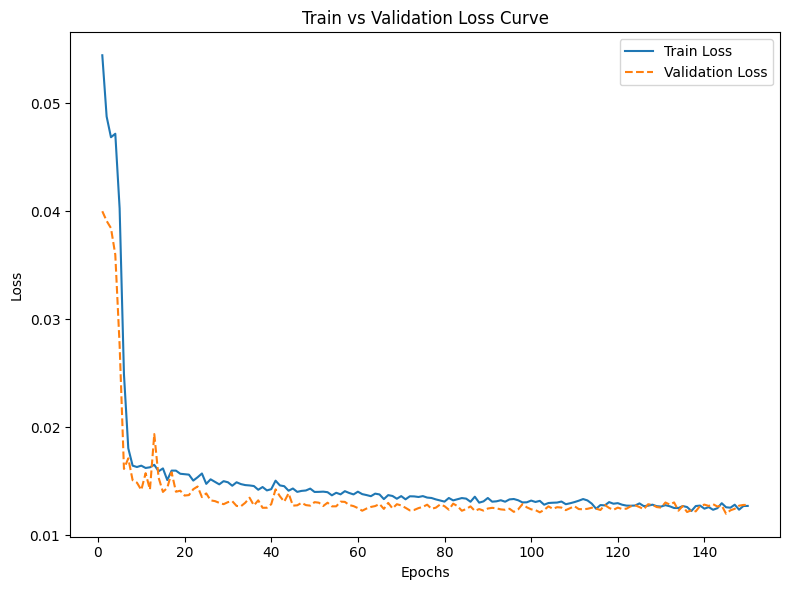

In [54]:
trained_model = train_transformer_decoder(model, train_loader, val_loader, epochs, learning_rate)

# Test

In [55]:
import numpy as np

In [56]:
def evaluate_test_set(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_values = []
    
    with torch.no_grad():  # Disable gradient computation for inference
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())  # Store predictions
            true_values.append(y_batch.cpu().numpy())  # Store true labels
    
    # Concatenate the results into single arrays
    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)
    
    return predictions, true_values


In [57]:
dataset.mode = 'test'

test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# check first batch
X_batch, y_batch = next(iter(test_loader))
print("\nSample from test_loader:")
print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)
print("X_batch:", X_batch)


Sample from test_loader:
X_batch shape: torch.Size([1, 3, 7])
y_batch shape: torch.Size([1, 1])
X_batch: tensor([[[0.0000, 0.0000, 0.2408, 0.0580, 0.0000, 0.3123, 1.0000],
         [0.0000, 0.0000, 0.0774, 0.1976, 0.0000, 0.4061, 0.6364],
         [0.0000, 0.0000, 0.0260, 0.2823, 0.0000, 0.3159, 0.3636]]])


In [58]:
predictions, true_values = evaluate_test_set(trained_model, test_loader, device)

R^2: 0.4120 RMSE: 0.1798


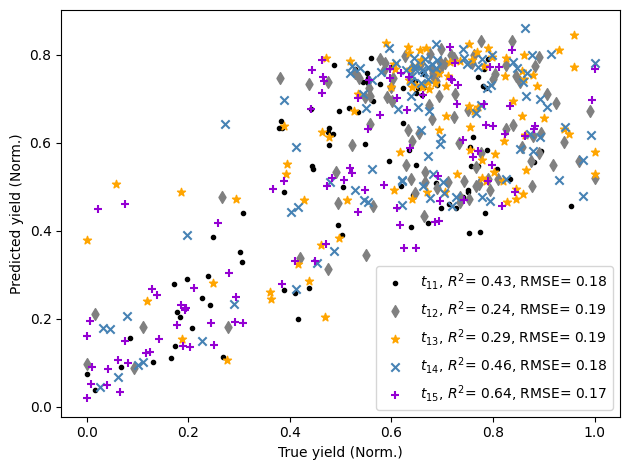

In [59]:
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress

# change true and predicted from (495, 1) to (5. 99)
true_values_reshaped = true_values.reshape(n_seq, -1)
predictions_reshaped = predictions.reshape(n_seq, -1)

scatter_marker = ['.','d','*','x','+','o','.','x','d','*']
scatter_color = ['black','gray','orange','steelblue','darkviolet','blue','pink','blue','pink','coral']

time_folds = [[4, 5, 6, 7, 8], [11, 12, 13, 14, 15]]

plt.figure()
r2_list = []
rmse_list = []

for time in range(n_seq):
    slope, intercept, r_value, p_value, std_err = linregress(true_values_reshaped[time, :], predictions_reshaped[time, :])
    r2 = r_value ** 2
    rmse = np.sqrt(mean_squared_error(true_values_reshaped[time], predictions_reshaped[time]))
    
    label = str(time_folds[k_fold-1][time])
    plt.scatter(true_values_reshaped[time, :], predictions_reshaped[time, :], marker = scatter_marker[time], color=scatter_color[time], label = f'$t_{{{label}}}$, $R^2$= {r2:.2f}, RMSE= {rmse:.2f}')
    r2_list.append(r2)
    rmse_list.append(rmse)

print(f"R^2: {np.mean(r2_list):.4f}", f"RMSE: {np.mean(rmse_list):.4f}")
plt.xlabel('True yield (Norm.)')
plt.ylabel('Predicted yield (Norm.)')
plt.legend()
plt.tight_layout()
plt.show()

R^2: 0.4120 RMSE: 30.9582


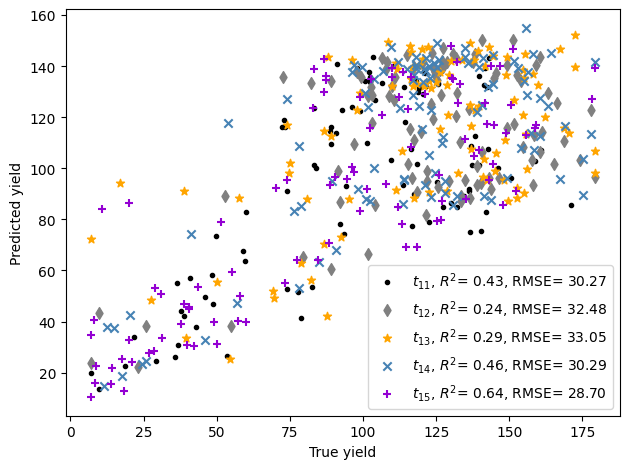

In [60]:
# Access the scaler
y_scaler = dataset.y_scaler

# Determine the number of expected features
expected_features = y_scaler.min_.shape[0]

# Pad true values and predictions
true_values_padded = np.zeros((true_values.shape[0], expected_features))
predictions_padded = np.zeros((predictions.shape[0], expected_features))

# Assign the actual values to the appropriate column (e.g., first column)
true_values_padded[:, 0] = true_values.flatten()
predictions_padded[:, 0] = predictions.flatten()

# Unnormalize and extract the relevant column
true_values_unnormalized = y_scaler.inverse_transform(true_values_padded)[:, 0]
predictions_unnormalized = y_scaler.inverse_transform(predictions_padded)[:, 0]

# Reshape for evaluation
true_values_reshaped_final = true_values_unnormalized.reshape(n_seq, -1)
predictions_reshaped_final = predictions_unnormalized.reshape(n_seq, -1)

scatter_marker = ['.','d','*','x','+','o','.','x','d','*']
scatter_color = ['black','gray','orange','steelblue','darkviolet','blue','pink','blue','pink','coral']

time_folds = [[4, 5, 6, 7, 8], [11, 12, 13, 14, 15]]

plt.figure()
r2_list = []
rmse_list = []

for time in range(n_seq):
    slope, intercept, r_value, p_value, std_err = linregress(
        true_values_reshaped_final[time, :], predictions_reshaped_final[time, :]
    )
    r2 = r_value ** 2
    rmse = np.sqrt(mean_squared_error(
        true_values_reshaped_final[time], predictions_reshaped_final[time]
    ))

    label = str(time_folds[k_fold-1][time])
    plt.scatter(
        true_values_reshaped_final[time, :], predictions_reshaped_final[time, :],
        marker=scatter_marker[time], color=scatter_color[time],
        label=f'$t_{{{label}}}$, $R^2$= {r2:.2f}, RMSE= {rmse:.2f}'
    )
    r2_list.append(r2)
    rmse_list.append(rmse)

print(f"R^2: {np.mean(r2_list):.4f}", f"RMSE: {np.mean(rmse_list):.4f}")
plt.xlabel('True yield')
plt.ylabel('Predicted yield')
plt.legend()
plt.tight_layout()
plt.show()
